## Data Import

<IPython.core.display.Javascript object>


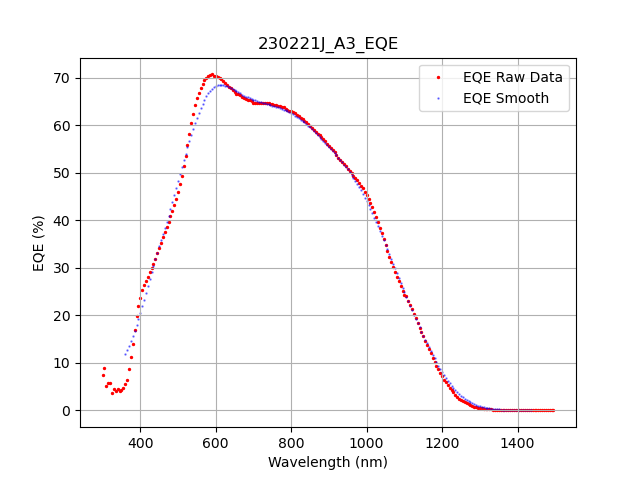

,Wavelength,EQE,Global tilt W*m-2*nm-1,EQE_smooth,number of photons per m2 per second,Jsc (mA/cm2),Integrated Jsc,hv,grad
0,300.0,7.55957,0.051589,NaN,7.791136e+16,0.000094,0.000094,4.133333,NaN
1,305.0,8.90827,0.301458,NaN,4.628603e+17,0.000660,0.000754,4.065574,NaN
2,310.0,5.23355,0.941031,NaN,1.468551e+18,0.001230,0.001984,4.000000,NaN
3,315.0,5.82802,1.644940,NaN,2.608458e+18,0.002432,0.004416,3.936508,NaN
4,320.0,5.76204,2.397760,NaN,3.862593e+18,0.003561,0.007977,3.875000,NaN
...,...,...,...,...,...,...,...,...,...
95,775.0,63.96950,5.877400,63.507432,2.293033e+19,0.234695,14.558796,1.600000,15.024791
96,780.0,63.77390,5.805500,63.346976,2.279594e+19,0.232606,14.791402,1.589744,16.551107
97,785.0,63.55420,5.719000,63.170320,2.260024e+19,0.229814,15.021217,1.579618,18.485238
98,790.0,63.31610,5.476800,62.975256,2.178097e+19,0.220654,15.241870,1.569620,20.251080


In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import cumtrapz
import matplotlib.ticker as ticker
from scipy.constants import Planck, speed_of_light

h = Planck #Planck's constant (h) in Joule seconds (J*s)
c = speed_of_light #Speed of light (c) in meters per second (m/s)

# Enable interactive plots in Jupyter Notebook
%matplotlib nbagg

# Set the path to the foldercontaining text files
folder_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\EQE\\230221J_EQE"
file_name = "230221J_A3_EQE.txt"
file_title = file_name.replace('.txt', '')

# Solar Iradiance data
solar_irradiance_path2 = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\EQE\\astmg173.xls"
irradiance_df2 = pd.read_excel(solar_irradiance_path2, sheet_name='SMARTS2', skiprows=1)
irradiance_df2 = irradiance_df2.apply(pd.to_numeric, errors='coerce')
irradiance_df2['Wavelength'] = irradiance_df2['Wavelength'].astype(float)

# Read the data from the text file, skipping the first lines
df = pd.read_csv(os.path.join(folder_path, file_name), sep="\t", header=None, names=["Wavelength", "EQE"])
df = df.apply(pd.to_numeric, errors='coerce')
df['Wavelength'] = df['Wavelength'].astype(float)

# Sort the dataframes by 'Wavelength' column
irradiance_df2.sort_values('Wavelength', inplace=True)
df.sort_values('Wavelength', inplace=True)

# Define the intervals based on the 'Wavelength' column in the main dataframe
intervals = [(df['Wavelength'].iloc[i], df['Wavelength'].iloc[i+1]) for i in range(len(df)-1)]

# Sum the 'Global tilt' values within each interval
merged_data = []
for interval in intervals:
    lower_bound, upper_bound = interval
    subset = irradiance_df2[(irradiance_df2['Wavelength'] >= lower_bound) & (irradiance_df2['Wavelength'] < upper_bound)]
    global_tilt_sum = subset['Global tilt  W*m-2*nm-1'].sum()
    merged_data.append([lower_bound, global_tilt_sum])
    
# Create a new dataframe with the merged data and append the EQE dataframe df to it
merged_df2 = pd.DataFrame(merged_data, columns=['Wavelength', 'Global tilt  W*m-2*nm-1'])
merged_df2 = df.merge(merged_df2[['Wavelength', 'Global tilt  W*m-2*nm-1']], on='Wavelength')
merged_df2 = merged_df2.apply(pd.to_numeric, errors='coerce') 

# Apply moving average filter to EQE data
window_size = 25
merged_df2['EQE_smooth'] = merged_df2['EQE'].rolling(window_size, center=True).mean()

# Calculations of Photon count, Integrated Jsc and gradient for bandgap
merged_df2['number of photons per m2 per second'] = merged_df2['Wavelength']*merged_df2['Global tilt  W*m-2*nm-1']*0.000000001/(h*c)
merged_df2['Jsc (mA/cm2)'] = merged_df2['EQE']*merged_df2['number of photons per m2 per second'] *0.001*1.6E-19
merged_df2['Integrated Jsc'] = np.cumsum(merged_df2['Jsc (mA/cm2)']) # Calculate the integrated Jsc
merged_df2['hv'] = 1240/merged_df2['Wavelength']
merged_df2['grad'] = np.gradient(np.abs(merged_df2['EQE_smooth']), merged_df2['hv'])

# Plot the data
fig = plt.subplots()
plt.scatter(merged_df2['Wavelength'], merged_df2['EQE'], s=2, c='r', label='EQE Raw Data')
plt.scatter(merged_df2['Wavelength'], merged_df2['EQE_smooth'], s=0.5, c='b', alpha=0.5, label='EQE Smooth')
plt.xlabel('Wavelength (nm)')
plt.ylabel('EQE (%)')
plt.legend()
plt.title(file_title)
plt.grid()

merged_df2.head(100)

## Spectral Irradiance Plots

<IPython.core.display.Javascript object>


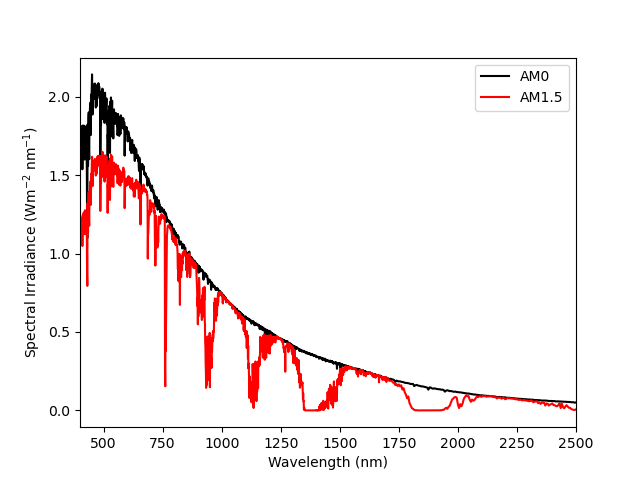

In [4]:
fig = plt.subplots()
plt.clf()
plt.plot(irradiance_df2['Wavelength'], irradiance_df2['Etr W*m-2*nm-1'], c='k', label='AM0')
plt.plot(irradiance_df2['Wavelength'], irradiance_df2['Global tilt  W*m-2*nm-1'], c='r', label='AM1.5')
# plt.plot(merged_df2['Wavelength'], merged_df2['Global tilt  W*m-2*nm-1'], c='g', label='AM1.5')
# plt.plot(irradiance_df2['Wvlgth nm'], irradiance_df2['Direct+circumsolar W*m-2*nm-1'], c='r', label='Direct+circumsolar')
plt.xlim(400,2500)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance (Wm$^{-2}$ nm$^{-1}$)')
plt.legend()

save_dir = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\EQE"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the plot as an image file
plt.savefig(os.path.join(save_dir, "Spectral Irradiance" + '.png'), dpi=500)

## Band Gap Calculation

<IPython.core.display.Javascript object>


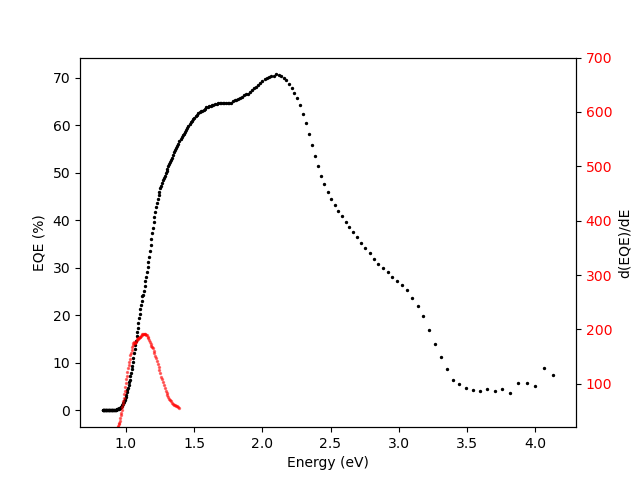

Maximum d(EQE)/dE value in masked data: 191.94894538709377
Electronic Band Gap: 1.1324200913242009


In [5]:
# Masked Data
x_min = 0.8
x_max = 1.4
mask = np.logical_and(merged_df2['hv'] >= x_min, merged_df2['hv'] <= x_max)
hv_subset = merged_df2['hv'][mask]
deqe_subset = merged_df2['grad'][mask]

# Plot
fig, ax1 = plt.subplots()
ax1.scatter(merged_df2['hv'], merged_df2['EQE'], s=2, c='k')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('EQE (%)')
#ax1.set_xlim(1.0,2)

ax2 = ax1.twinx()
ax2.scatter(hv_subset, deqe_subset, c='r', s=2, alpha=0.5, label='d(EQE)/dE')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('d(EQE)/dE')
ax2.set_ylim(20, 700)
#ax2.set_xlim(1.0,2)

# Calculate maximum deqe value and it's index in the masked data
max_deqe = np.max(deqe_subset)
max_deqe_index = np.argmax(deqe_subset)

# Get the corresponding hv_subset value
band_gap = hv_subset.iloc[max_deqe_index]

# Print the maximum deqe value and its corresponding hv_subset value
print("Maximum d(EQE)/dE value in masked data:", max_deqe)
print("Electronic Band Gap:", band_gap)

<IPython.core.display.Javascript object>


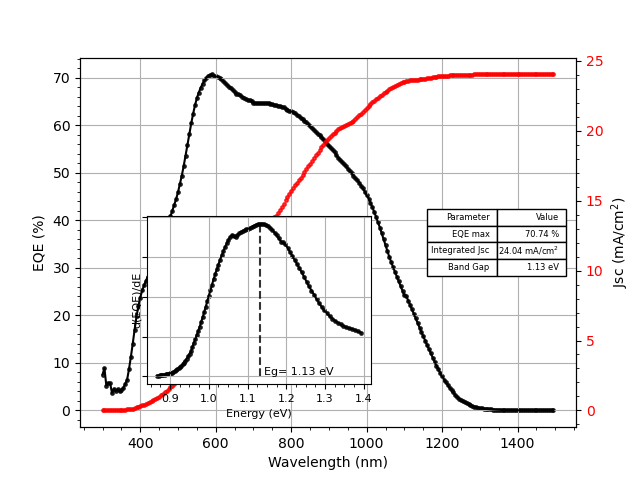

In [6]:
# Plot the data
fig, ax1 = plt.subplots()

ax1.scatter(merged_df2['Wavelength'], merged_df2['EQE'], s=6, c='k', alpha=0.8)
ax1.plot(merged_df2['Wavelength'], merged_df2['EQE'], c='k')
ax1.set_ylabel('EQE (%)')
ax1.set_xlabel('Wavelength (nm)')
ax1.grid()
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2))
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.yaxis.set_tick_params(which='both', labelbottom=True)

ax2 = ax1.twinx()
ax2.scatter(merged_df2['Wavelength'], merged_df2['Integrated Jsc'], s=6, c='r', alpha=0.8)
ax2.set_ylabel('Jsc (mA/cm$^2$)')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))

# Add a table with parameters
table_data = [
    ['Parameter', 'Value'],
    ['EQE max', "{:.2f}".format(np.max(merged_df2['EQE'])) + ' %'],
    ['Integrated Jsc', "{:.2f}".format(np.max(merged_df2['Integrated Jsc'])) + ' mA/cm$^2$'],
    ['Band Gap', "{:.2f}".format(band_gap) + ' eV']
]

table = plt.table(cellText=table_data, colWidths=[0.35, 0.35], loc='center right')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(0.4, 1.0)

# Create a second axes for the additional plot in the top right corner
ax3 = fig.add_axes([0.23, 0.2, 0.35, 0.35])  # Adjust the position and size as needed

ax3.scatter(hv_subset, deqe_subset, label='d(EQE)/dE', s=6, c='k', alpha=0.8)
ax3.plot(hv_subset, deqe_subset, c='k')
ax3.tick_params(axis='y', labelleft= False)
ax3.tick_params(axis='x', labelsize=8)
ax3.set_ylabel('d(EQE)/dE', fontsize=8)
ax3.set_xlabel('Energy (eV)', fontsize=8)
ax3.xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax3.vlines(band_gap, 0, max_deqe, colors='k', linestyles='--', alpha=0.8)
ax3.grid()

ax3.text(band_gap + 0.01, 2, "Eg= {:.2f} eV".format(band_gap), fontsize=8)

plt.show()

save_dir = os.path.join(folder_path, 'EQE Plots')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the plot as an image file
plt.savefig(os.path.join(save_dir, file_title + '1.png'), dpi=500)